### Feature Impacts on Noisy Data
We will generate data points randomly for both training and test sets, and see if our feature tracking methods can help in a model's training phase when data is extremely noisy.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from helper_plots import plot_feature_importances_per_iter, plot_feature_impacts_per_iter, plot_total_feature_impacts, plot_prediction_feature_impacts

C:\Users\cf660\AppData\Local\Temp\ipykernel_5564\3152192989.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
np.random.seed(42)
n_samples = 1000

predictive_strengths = np.array([0.25, 0.2, 0.2, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05, 0.05, 0, 0, 0, 0, 0])
df = pd.DataFrame({
    f'feature_{i}': np.random.rand(n_samples) for i in range(1, 16)
})

# Generate a continuous target variable influenced by the predictive features
noise = np.random.randn(n_samples) * 0.15  # Noise level
signals = sum([df[f'feature_{i+1}'] * predictive_strengths[i] for i in range(15)])

df['target'] = signals + noise

feature_name_mappings = {i: f'feature_{i+1}' for i in range(15)}


X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,target
0,0.374540,0.185133,0.261706,0.672703,0.571996,0.393636,0.648257,0.038799,0.720268,0.913578,0.373641,0.533031,0.654306,0.974318,0.073175,0.809644
1,0.950714,0.541901,0.246979,0.796681,0.805432,0.473436,0.172386,0.186773,0.687283,0.525360,0.332912,0.137899,0.080033,0.017173,0.089478,0.769988
2,0.731994,0.872946,0.906255,0.250468,0.760161,0.854547,0.872395,0.831246,0.095754,0.724910,0.176154,0.591243,0.242330,0.947652,0.651974,0.823022
3,0.598658,0.732225,0.249546,0.624874,0.153900,0.340004,0.613116,0.766768,0.922572,0.436048,0.607267,0.314786,0.773679,0.368677,0.486941,0.682869
4,0.156019,0.806561,0.271950,0.571746,0.149249,0.869650,0.157204,0.350643,0.568472,0.630035,0.476624,0.052349,0.528686,0.010090,0.790415,0.460419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.091582,0.656955,0.865296,0.442107,0.897397,0.684435,0.579737,0.273160,0.514929,0.857656,0.359445,0.004644,0.940234,0.424338,0.650883,0.628559
996,0.917314,0.956615,0.157273,0.334401,0.119381,0.503220,0.667037,0.209519,0.165370,0.897509,0.926708,0.873669,0.692909,0.915691,0.177798,0.729869
997,0.136819,0.068958,0.309788,0.394572,0.327843,0.765149,0.911577,0.455329,0.977713,0.946708,0.698657,0.307325,0.867619,0.497938,0.051240,0.601318
998,0.950237,0.057055,0.290046,0.529941,0.815745,0.485291,0.345620,0.908438,0.107925,0.397488,0.257177,0.938589,0.366457,0.398837,0.682962,0.580774


In [3]:
from feature_tracker import CustomGBR
# Train CustomGBR with early stopping
gbr = CustomGBR(n_estimators=500, learning_rate=0.01, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.0001, random_state=42)
gbr.fit(X_train, y_train)
print(f'gbr fit with {gbr.n_estimators_} estimators from early stopping')

gbr fit with 256 estimators from early stopping


#### Comparing feature tracking vs traditional early stopping methods

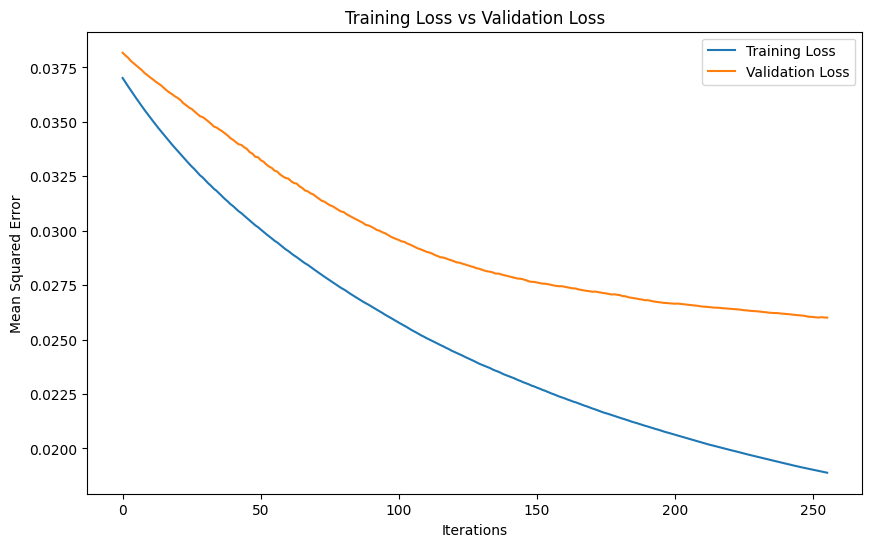

In [4]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse_train = [mean_squared_error(y_train, y_pred) for y_pred in gbr.staged_predict(X_train)]
mse_test = [mean_squared_error(y_test, y_pred) for y_pred in gbr.staged_predict(X_test)]

# Plotting the training loss vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(mse_train, label='Training Loss')
plt.plot(mse_test, label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

#### Normal Feature Importances

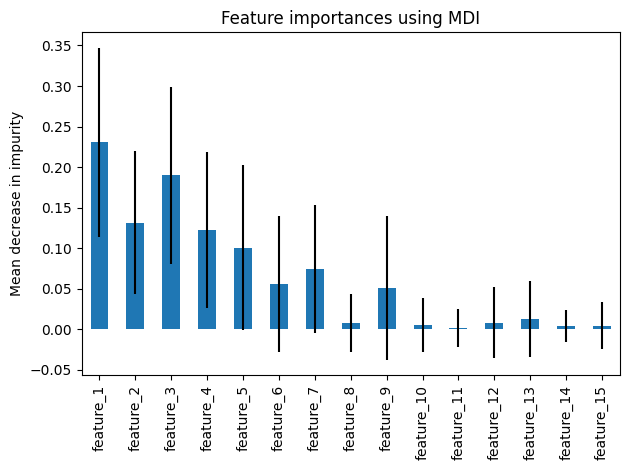

In [5]:
importances = gbr.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gbr.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_name_mappings.values())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [6]:
from sklearn.inspection import permutation_importance
r = permutation_importance(gbr, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > -1:
        print(f"{feature_name_mappings[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

feature_1 0.141 +/- 0.028
feature_2 0.128 +/- 0.021
feature_3 0.089 +/- 0.028
feature_5 0.046 +/- 0.012
feature_4 0.031 +/- 0.012
feature_7 0.016 +/- 0.010
feature_9 0.013 +/- 0.008
feature_6 0.004 +/- 0.008
feature_13 0.003 +/- 0.002
feature_14 0.002 +/- 0.002
feature_11 -0.000 +/- 0.000
feature_12 -0.000 +/- 0.001
feature_10 -0.003 +/- 0.001
feature_15 -0.004 +/- 0.001
feature_8 -0.005 +/- 0.003


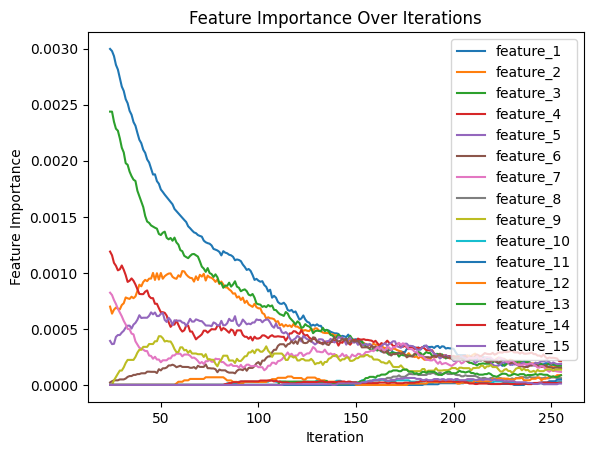

In [7]:
feature_importances_per_iter = gbr.get_feature_importance_per_iteration()
plot_feature_importances_per_iter(feature_importances_per_iter, feature_name_mappings)

As we can see, in the presence of extremely noisy data, some stronger feature influences are unable to be picked up by feature importance. <br>
This is because all features barely improve MSE.

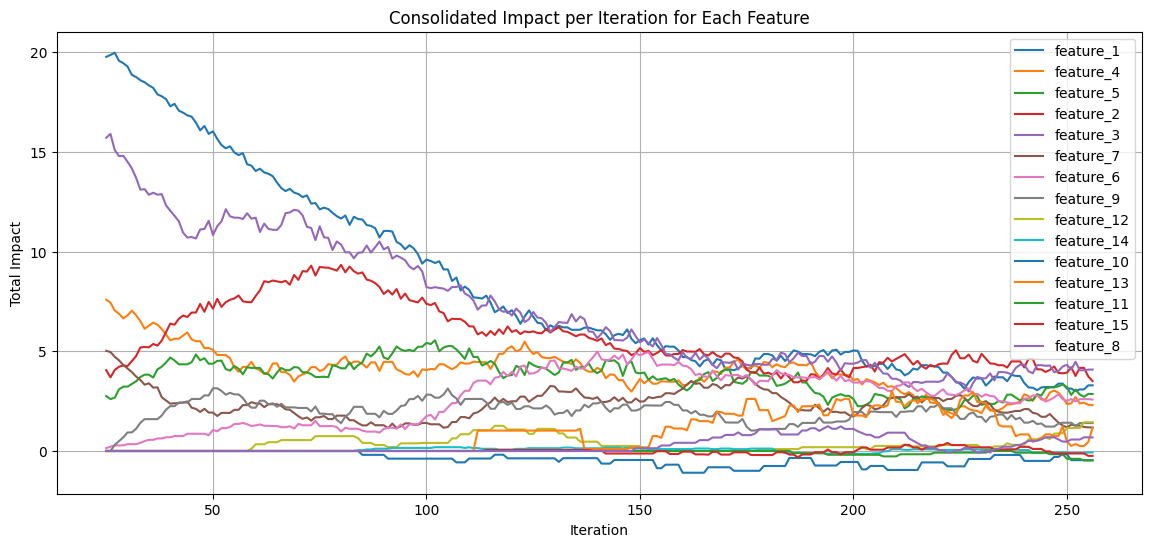

In [8]:
gbr.abs_impact = False
feature_impacts_per_iter = gbr.get_feature_impacts_per_iteration()
plot_feature_impacts_per_iter(feature_impacts_per_iter, weighted_by_samples=True, feature_name_mappings=feature_name_mappings)

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")

Mean Squared Error (MSE): 0.02601
Mean Absolute Error (MAE): 0.13158


In [10]:
# Train CustomGBR with stopping decided by feature tracking
gbr = CustomGBR(n_estimators=6, learning_rate=0.1, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.001, random_state=42)
gbr.fit(X_train, y_train)


CustomGBR(n_estimators=6, n_iter_no_change=10, random_state=42, tol=0.001,
          validation_fraction=0.2)

In [11]:
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")

Mean Squared Error (MSE): 0.03254
Mean Absolute Error (MAE): 0.14391


c:\Users\cf660\Desktop\fyp\code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


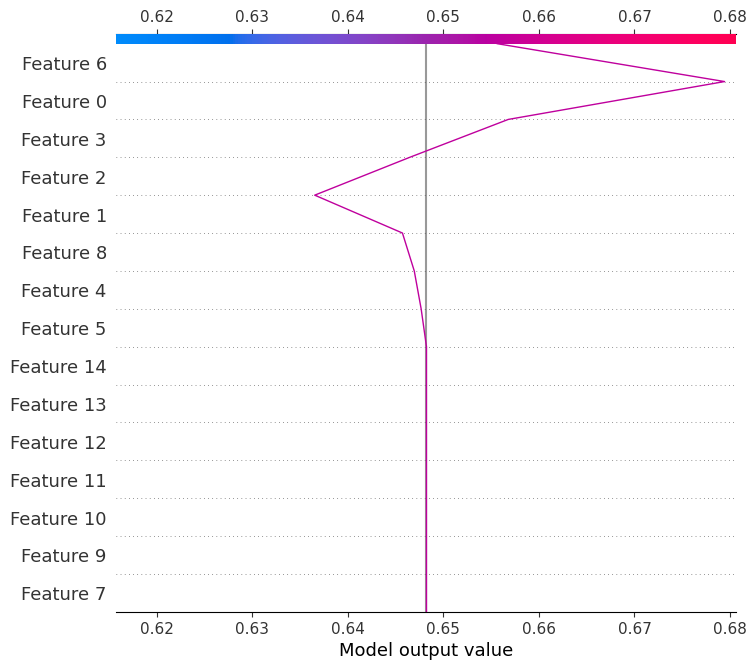

array([ 0.02264499, -0.00918563,  0.00995563,  0.0103085 , -0.00072051,
       -0.00055864, -0.02379904,  0.        , -0.00123607,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [12]:
import shap
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(X_test.iloc[1, :])
shap.decision_plot(explainer.expected_value, shap_values)
shap_values


In [13]:
gbr.abs_impact = False
gbr.get_predictions_feature_impacts(X_test).groupby('feature').mean()

,threshold,iteration,impact
feature,,,
0,0.590162,3.432789,6.285896
1,0.573556,3.754673,2.156229
2,0.552431,3.089532,3.665438
3,0.412574,3.577488,3.291107
4,0.366413,4.554545,2.638439
5,0.473734,3.872727,0.784959
6,0.307328,3.269406,2.224574
8,0.260593,4.000000,1.886276
